# RDKit workshop

In the following, RDKit will be applied to explore a chemical dataset (Delaney) on the solubility of various substances in water (logS(mol/L)).

### Part 1: Data loading and exploration

Inspect the dataset and visualise the solubility distribution (EDA). Tasks:
- How many compounds are in the dataset?
- What is the average and range of the solubility values in the dataset?
- Are there extreme outliers (e.g. box plot)?

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("delaney.csv")
display(df)
print(min(df['logS']), max(df['logS']), '\n', df['logS'].mean(), df['logS'].std())  
display(df.describe()) # optional: df['logS'].describe() to just describe an explicit column
# unique compounds:
print(len(df['Compound ID'].unique()))
print(len(df['SMILES'].unique()))

,Compound ID,logS,SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...
1139,vamidothion,1.144,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


-11.6 1.58 
 -3.0579973776223777 2.0965019290656026


,logS
count,1144.000000
mean,-3.057997
std,2.096502
min,-11.600000
25%,-4.332250
50%,-2.870500
75%,-1.600000
max,1.580000


1143
1128


# first few commands we do with every dataset
df.info()
df.describe() # summary statistics: big tail on the negative side (small solubility)

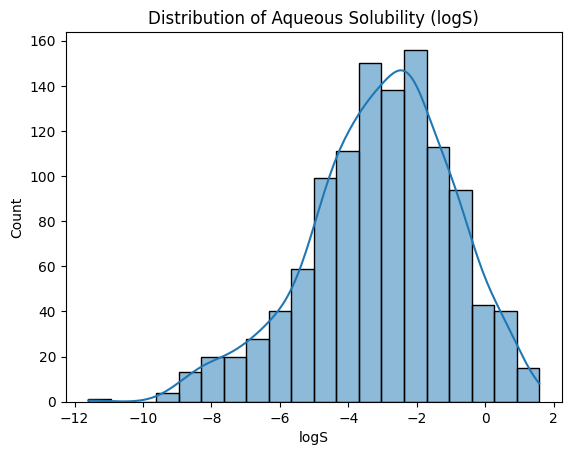

In [20]:

sns.histplot(df['logS'], bins=20, kde=True)
plt.title("Distribution of Aqueous Solubility (logS)")
plt.show()

<Axes: ylabel='logS'>

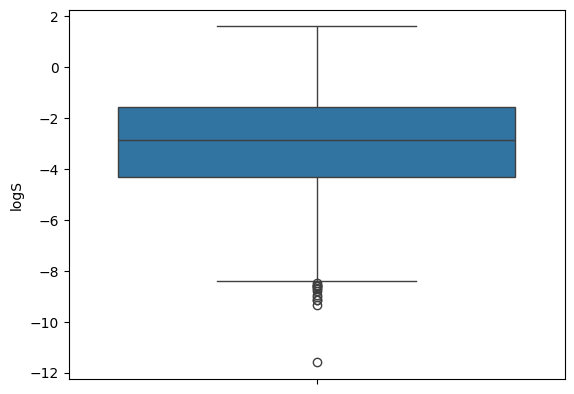

In [6]:
# look for outliers and symmetry
# reminder: only remoe outliers if you have a good reason to do so! here: hard to judge besides chemical intuition
sns.boxplot(df['logS'])

### Part 2: Compute descriptors with RDKit

Calculate molecular descriptors from the SMILES. See snippet below for the syntax of doing so.

Tasks:
- Compute 5-10 descriptors based on the SMILES (e.g. use the apply() method in pandas) and add them to the DataFrame
- Find out if there is any correlation of the descriptors and the solubility (e.g. plots)

Some info on available descriptors: 
- https://github.com/hypowergravity/RDKitDescriptorExamples-
- https://schwallergroup.github.io/practical-programming-in-chemistry/tutorials/lecture_05/02_rdkit_descriptors.html
- https://deepwiki.com/rdkit/rdkit/6.1-chemical-reactions#molecular-descriptors-and-properties

MD:
1st: long list of descriports. select roughly 10 descriptors and add them to the df. then find if some descriptors correlate with the solubilities.
use: MolWt, MolLogP, MaxPartialCharge, Phi(Flexibility Index), RingCount, NumHeterocycles, NumAmideBonds, fr_COO

In [11]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Syntax for deriving descriptors:
# 1) convert smiles to Mol: mol = Chem.MolFromSmiles(smiles)
# 2) derive descriptor, e.g. for MolWt: descr = Descriptors.MolWt(mol)

descr_list = ['MolWt', 'MolLogP', 'MaxPartialCharge', 'TPSA', 'SPS', 'NumHDonors', 'NumHAcceptors', 'Phi', 'RingCount', 'NumHeterocycles', 'NumAmideBonds', 'fr_COO']

def calc_descriptors(smiles, descr):
    mol = Chem.MolFromSmiles(smiles)
    return getattr(Descriptors, descr)(mol)

# for descr in descr_list:
#     df[descr] = df["SMILES"].apply(lambda s: calc_descriptors(s, descr))

df["MolWt"] = df["SMILES"].apply(lambda s: Descriptors.MolWt(Chem.MolFromSmiles(s)))
df["MolLogP"] = df["SMILES"].apply(lambda s: Descriptors.MolLogP(Chem.MolFromSmiles(s)))
df["NumHeteroatoms"] = df["SMILES"].apply(lambda s: Descriptors.NumHeteroatoms(Chem.MolFromSmiles(s)))

df.head()

,Compound ID,logS,SMILES,MolWt,MolLogP,NumHeteroatoms
0,"1,1,1,2-Tetrachloroethane",-2.18,ClCC(Cl)(Cl)Cl,167.850,2.5954,4
1,"1,1,1-Trichloroethane",-2.00,CC(Cl)(Cl)Cl,133.405,2.3765,3
2,"1,1,2,2-Tetrachloroethane",-1.74,ClC(Cl)C(Cl)Cl,167.850,2.5938,4
3,"1,1,2-Trichloroethane",-1.48,ClCC(Cl)Cl,133.405,2.0289,3
4,"1,1,2-Trichlorotrifluoroethane",-3.04,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.9189,6


### Part 3: Predict solubility (Regression Model)

Use the code below to predict the logS using a RandomForestRegressor:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# separate training features X and target variable y
X = df.drop(columns=["logS", "Compound ID", "SMILES"], axis=1) # drop non-numeric columns and target (dependent) variable
display(X.head())
y = df["logS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # pseudo-random state for reproducibility
model = RandomForestRegressor(n_estimators=200, random_state=42) # n_estimators: hyperparameters, e.g. number of trees
model.fit(X_train, y_train) # train the model with the fit function
pred = model.predict(X_test) # make predictions on the test set

# compare predictions to true values
print("R²:", r2_score(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("train accuracy:", model.score(X_train, y_train))
print("test accuracy:", model.score(X_test, y_test))

# high train accuracy and low test accuracy indicates slight overfitting

Based on the EDA, which descriptors might influence the solubility the most?

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()

### Part 4: Similarity Search

Create fingerprints from the SMILES and add them to the dataframe.

In [ ]:
from rdkit.Chem import rdFingerprintGenerator, DataStructs

# use e.g. the morgan FPG: mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)



Calculate the Tanimoto similarity of the molecules in the dataframe in comparison to a molecule of your choice (e.g. caffeine, aniline, ethanol).

In [27]:
query_fp = mol2fp("Nc1ccccc1")
print(query_fp)

df["similarity"] = df["fingerprint"].apply(lambda fp: DataStructs.TanimotoSimilarity(fp, query_fp))
df.head()
df.describe()

In [29]:
query_fp = mol2fp("OCC") # Ethanol
print(query_fp)

df["similarity"] = df["fingerprint"].apply(lambda fp: DataStructs.TanimotoSimilarity(fp, query_fp))
df.head()
df.describe()
df['similarity'].nlargest(10)

642    1.000000
114    0.555556
987    0.428571
66     0.416667
110    0.384615
209    0.384615
461    0.375000
141    0.363636
243    0.363636
77     0.357143
Name: similarity, dtype: float64

In [30]:
query_fp = mol2fp("Nc1ccccc1") # aniline
print(query_fp)

df["similarity"] = df["fingerprint"].apply(lambda fp: DataStructs.TanimotoSimilarity(fp, query_fp))
df.describe()
df['similarity'].nlargest(10)

394     1.000000
910     0.466667
916     0.466667
440     0.428571
913     0.411765
920     0.411765
970     0.411765
783     0.400000
844     0.400000
1006    0.400000
Name: similarity, dtype: float64

In [28]:
df["similarity"].nlargest(10)

394     1.000000
910     0.466667
916     0.466667
440     0.428571
913     0.411765
920     0.411765
970     0.411765
783     0.400000
844     0.400000
1006    0.400000
Name: similarity, dtype: float64

### Part 5: Clustering molecules by strucutre

Use fingerprints to group molecules into clusters (using k-means clustering) and visualise via PCA. Tasks:
- Experiment with different numbers of clusters
- Compute the average solubility per cluster
- Do certain clusters correspond to highly or poorly soluble compounds?

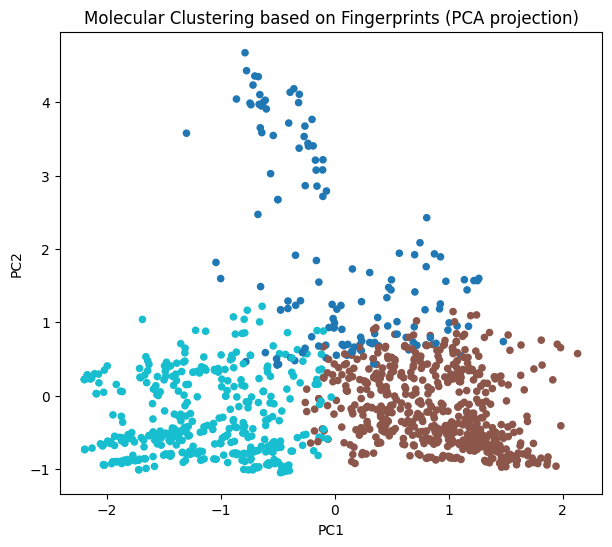

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

fps = df["fingerprint"].to_list()


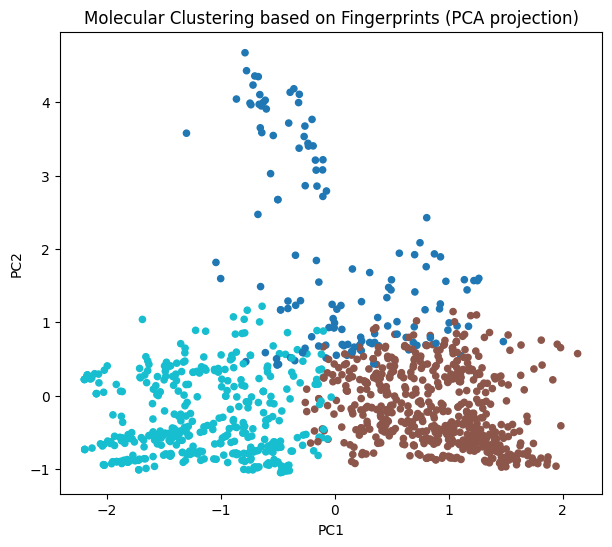

In [37]:

# Reduce dimensionality for visualization
pca = PCA(n_components=2) # fingerprint are high-dimensional (2048), reduce to 2D for visualization
X_pca = pca.fit_transform(fps)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(fps)
df["cluster"] = clusters

# Visualize clusters
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="tab10", s=20)
plt.title("Molecular Clustering based on Fingerprints (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [ ]:
print(df.groupby("cluster")["logS"].mean())

cluster
0   -4.041540
1   -3.574464
2   -2.094190
Name: logS, dtype: float64


In [ ]:
# we check if compounds have an aromatic ring
df["has_aromat"] = df["SMILES"].apply(lambda s: Chem.MolFromSmiles(s).HasSubstructMatch(Chem.MolFromSmarts("a")))
pd.crosstab(df["cluster"], df["has_aromat"]) # table showing counts of aromatic vs non-aromatic compounds in each cluster

### Part 6: Substructure Search via SMARTS

Search for specific functional groups or chemical motifs within the dataset using SMARTS (SMiles ARbitrary Target Specification): e.g. alcohol = "[OX2H]", carboxylic acid = "C(=O)[OH]", aromatic compounds = "a", amines = "[NX3;H2,H1;!$(NC=O)]"

See here for a more detailed list of SMARTS: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html 

Tasks:
- Count how many molecules contain each functional group (method: Mol.HasSubstructMatch(SMARTS)).
- Compare average solubility for molecules with vs. without each substructure.
- Visualize with a bar plot.

In [ ]:
from rdkit import Chem

patterns = {
    "Hydroxyl": Chem.MolFromSmarts("[OX2H]"),
}




In [ ]:
df[list(patterns.keys())].sum()

In [ ]:
for name in patterns.keys():
    print(df.groupby(name)["logS"].mean())

# now we can see: e.g. if hydroxyl is present, the average logS is higher, means comopounds are more soluble

In [ ]:
import seaborn as sns
means = {}

for name in patterns.keys():
    mean_series = df.groupby(name)["logS"].mean()
    if len(mean_series) > 1:
        val = mean_series.iloc[1]
        means[name] = val
    else:
        print(f"No {name} in dataset")

sns.barplot(x=list(means.keys()), y=list(means.values()))
plt.title("Average Solubility by Functional Group Presence")
plt.ylabel("Mean logS")
plt.show()